# Transfer function parameters identification (based on experimental data).

A dynamic system has been excited using a step on its input.

The system's output $y(t)$ has been logged; the logging started when the step was applied, so when $t=0$. The
recorded datas are available in the file "data_system_ok.npz".

One would like to approximate this dynamic system with a model build on a second order transfer function
having 2 real poles and a dead-time : $$H_m(s) = \frac{Ke^{-sT_m}}{(sT_1 + 1)(sT_2 + 1)}$$

with:
- $K$, the system's static gain
- $T_m$, the dead-time
- $T_1$ and $T_2$, the 2 time constants

You're asked to :
- Find the transfer function's parameters, ensuring its step answer would fit as good as possible to the
experimental data. (Remember the tutorial about optimization)
- Plot on one unique chart the experimental datas and the model's answer, using for this one 500 points
equally distributed on the time duration of the experimental data.
- Compute and plot the model's poles in the complex domain.

In [15]:
import numpy as np
from matplotlib import pyplot as plt
import control as ct
from scipy.optimize import minimize

%config InlineBackend.figure_formats = ['svg']

In [16]:
npzfile = np.load('data_system_ok.npz')
npzfile

NpzFile 'data_system_ok.npz' with keys: t, y

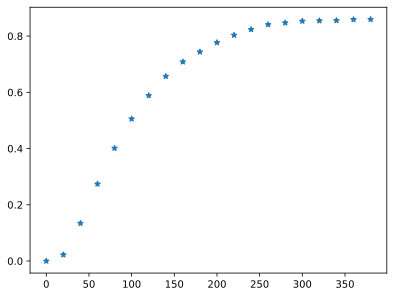

In [17]:
t = npzfile['t']
y = npzfile['y']
plt.plot(t, y, '*')
plt.show()

In [18]:
# The control package can't represent the delay part of the system exp(-s*Tm)
# so we will use a Padé approximation

def delay(T):
    num, den = ct.pade(T, 5) # 5th-order Padé approximation
    return ct.tf(num, den)

def no_delay(P):
    s = ct.tf('s')
    assert s is not None
    return P[0]/((s*P[2]+1)*(s*P[3]+1))

def syst(P):
    syst_no_dead_time = no_delay(P)
    dead_time = delay(P[1])
    return syst_no_dead_time * dead_time

def response(P, t):
    H = syst(P)
    _, y = ct.step_response(H, t)
    return y

def cost(P, t, fun, y):
    return np.linalg.norm(fun(P, t) - y)

res = minimize(lambda P: cost(P, t, response, y), [1, 25, 50, 50], method='Nelder-Mead')
P_opt = res.x
P_opt

array([ 0.87240194,  9.01488149, 70.84910922, 26.13143975])

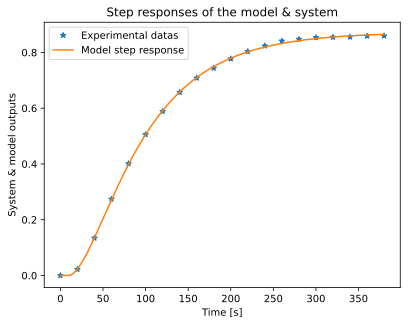

In [19]:
tm=np.linspace(0,t[-1],500)
ym=response(P_opt,tm)
assert ym is not None
plt.plot(t,y,'*', label="Experimental datas")
plt.plot(tm, ym, label="Model step response")
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('System & model outputs')
plt.title('Step responses of the model & system')
plt.show()

[-0.51574151+0.79225066j -0.51574151-0.79225066j -0.74364958+0.38661882j
 -0.74364958-0.38661882j -0.80904859+0.j         -0.03826808+0.j
 -0.0141145 +0.j        ]


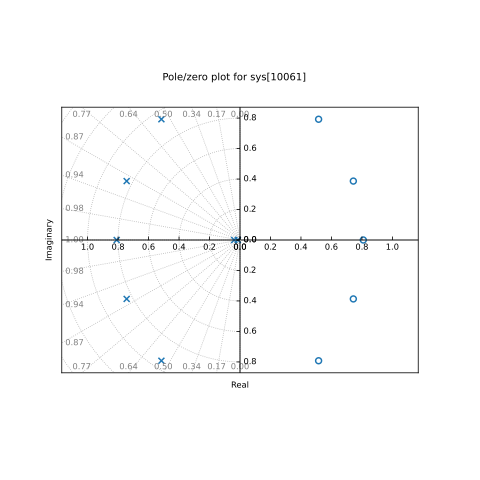

In [20]:
H = syst(P_opt)

# To much poles and zeros ! Some of them comes from the pade approximation
print(ct.poles(H))
ct.pzmap(H, grid=True)
plt.show()

In [21]:
G_delay = delay(P_opt[1])
ct.poles(G_delay)

array([-0.51574151+0.79225066j, -0.51574151-0.79225066j,
       -0.80904859+0.j        , -0.74364958+0.38661882j,
       -0.74364958-0.38661882j])

In [22]:
# The delay should not introduce any poles nor zeros so we only
# need to compute the poles of the non-delayed part of the system
H_no_delay = no_delay(P_opt)
ct.poles(H_no_delay)

array([-0.03826808+0.j, -0.0141145 +0.j])

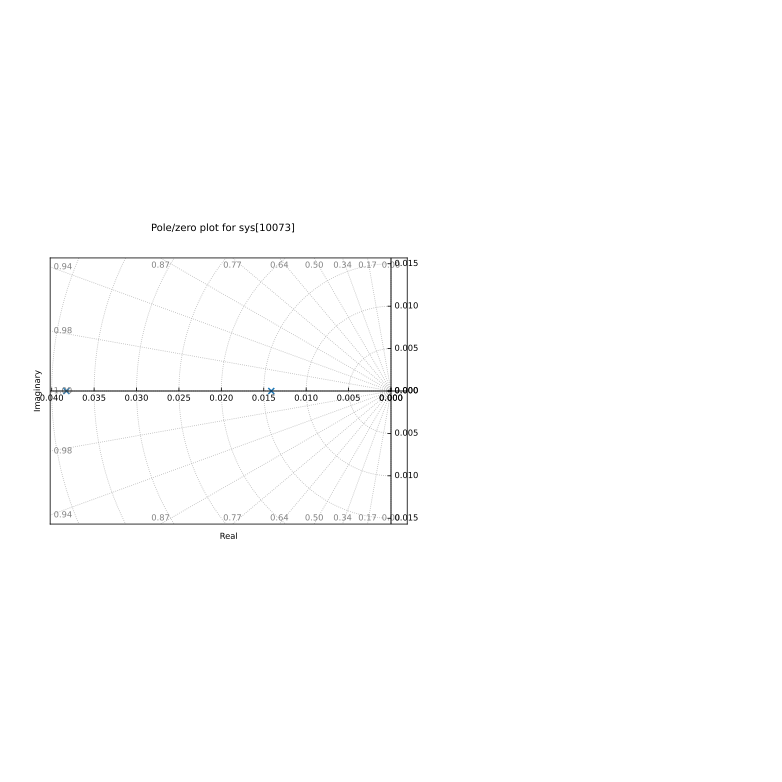

In [23]:
ct.pzmap(H_no_delay, grid=True)
plt.show()

# Avec `sympy`

In [29]:
import sympy as sp
t, s = sp.symbols('t, s')

In [25]:
npzfile = np.load('data_system_ok.npz')
t_data = npzfile['t']
y_data = npzfile['y']

In [26]:
def syst_sp(P):
    return P[0] * sp.exp(-s * P[1]) / ((s*P[2] + 1)*(s*P[3] + 1))

def response_sp(P, t_data):
    H = syst_sp(P)
    step_response = sp.inverse_laplace_transform(H/s, s, t)
    step_response = sp.lambdify(t, step_response, "numpy")
    return step_response(t_data)

res = minimize(lambda P: cost(P, t_data, response_sp, y_data), [1, 25, 50, 50], method='Nelder-Mead')
P_opt_sp = res.x
P_opt_sp


array([ 0.8724019 ,  9.01496589, 70.84921164, 26.13125881])

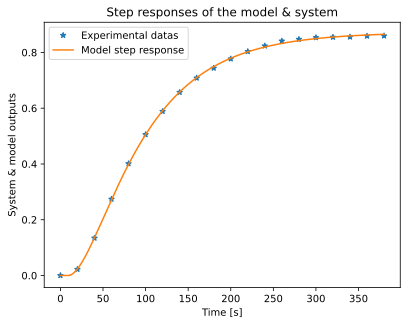

In [27]:
tm=np.linspace(0,t_data[-1],500)
ym=response_sp(P_opt_sp,tm)
plt.plot(t_data, y_data, '*', label="Experimental datas")
plt.plot(tm, ym, label="Model step response")
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('System & model outputs')
plt.title('Step responses of the model & system')
plt.show()

In [28]:
num = P_opt_sp[0] * sp.exp(-s * P_opt_sp[1])
den = ((s*P_opt_sp[2] + 1)*(s*P_opt_sp[3] + 1))
zeros = sp.solve(num, s)
poles = sp.solve(den, s)
print("Zeros:", zeros)
print("Poles:", poles)

Zeros: []
Poles: [-0.0382683439449769, -0.0141144830960582]
